In [1]:
import os
import random
import numpy as np
import pandas as pd
import geopandas as gpd
from skimage import io
from shapely.geometry import Polygon

import torch
from torch.utils.data import Dataset
from pycocotools.coco import COCO

from dataset_preparing import get_coords_from_densifing_points, generate_heatmap
# dense에 대한 간격이나 표준편차를 하이퍼 파라미터로 조정가능한 코드. 히트맵 생성 때문에 속도는 좀 걸릴 수 있음
# Inria 데이터 크기 조정하여 coco 포맷으로 맞춰준 데이터 처리가능

def min_max_normalize(image, percentile, nodata=-1.):
    image = image.astype('float32')
    mask = np.mean(image, axis=2) != nodata * image.shape[2]

    percent_min = np.percentile(image, percentile, axis=(0, 1))
    percent_max = np.percentile(image, 100-percentile, axis=(0, 1))

    if image.shape[1] * image.shape[0] - np.sum(mask) > 0:
        mdata = np.ma.masked_equal(image, nodata, copy=False)
        mdata = np.ma.filled(mdata, np.nan)
        percent_min = np.nanpercentile(mdata, percentile, axis=(0, 1))

    norm = (image-percent_min) / (percent_max - percent_min)
    norm[norm < 0] = 0
    norm[norm > 1] = 1
    norm = (norm * 255).astype('uint8') * mask[:, :, np.newaxis]

    return norm


def image_graph_collate_road_network_coco(batch):
    images = torch.stack([item['image'] for item in batch], 0).contiguous()
    heatmap = torch.stack([item['heatmap'] for item in batch], 0).contiguous()
    points = [item['nodes'] for item in batch]
    edges = [item['edges'] for item in batch]

    return [images, heatmap, points, edges]


def create_polygon(segmentation):
    # COCO segmentation format is [x1, y1, x2, y2, ..., xn, yn]
    # We need to reshape it to [(x1, y1), (x2, y2), ..., (xn, yn)]
    points = list(zip(segmentation[::2], segmentation[1::2]))
    return Polygon(points)


def gdf_to_nodes_and_edges(gdf):
    nodes = []
    for _, row in gdf.iterrows():
        polygon = row['geometry']
        if polygon.geom_type == 'Polygon':
            for x, y in polygon.exterior.coords:
                nodes.append((x, y))
        elif polygon.geom_type == 'MultiPolygon':
            for part in polygon:
                for x, y in part.exterior.coords:
                    nodes.append((x, y))
        else:
            raise AttributeError

    # Remove duplicates if necessary
    nodes = list(set(nodes))

    # Create a DataFrame for nodes with unique indices
    node_df = pd.DataFrame(nodes, columns=['x', 'y'])
    node_df['node_id'] = range(len(node_df))

    edges = []
    for _, row in gdf.iterrows():
        polygon = row['geometry']
        if polygon.geom_type == 'Polygon':
            coords = polygon.exterior.coords[:-1]  # Exclude closing vertex
            edge = [(node_df[(node_df['x'] == x) & (node_df['y'] == y)].index[0], 
                    node_df[(node_df['x'] == coords[(i+1)%len(coords)][0]) & (node_df['y'] == coords[(i+1)%len(coords)][1])].index[0]) 
                    for i, (x, y) in enumerate(coords)]
            edges.extend(edge)
        elif polygon.geom_type == 'MultiPolygon':
            for part in polygon:
                coords = part.exterior.coords[:-1]
                edge = [(node_df[(node_df['x'] == x) & (node_df['y'] == y)].index[0], 
                        node_df[(node_df['x'] == coords[(i+1)%len(coords)][0]) & (node_df['y'] == coords[(i+1)%len(coords)][1])].index[0]) 
                        for i, (x, y) in enumerate(coords)]
                edges.extend(edge)

    return node_df[['y', 'x']].values, edges


class CrowdAI(Dataset):
    """A dataset class for handling and processing data from the CrowdAI dataset.

    Attributes:
        IMAGES_DIRECTORY (str): Directory containing the images.
        ANNOTATIONS_PATH (str): File path for the annotations.
        coco (COCO): COCO object to handle COCO annotations.
        max_points (int): Maximum number of points to consider (default 256).
        gap_distance (float): Distance between interpolated points.
        sigma (float): Standard deviation for Gaussian kernel used in heatmap generation.

    Args:
        images_directory (str): Directory where the dataset images are stored.
        annotations_path (str): File path for the COCO format annotations.
        gap_distance (int, optional): Gap distance for densifying points. Defaults to 20.
        sigma (float, optional): Sigma value for Gaussian blur in heatmap. Defaults to 1.5.
    """

    def __init__(self, 
                 images_directory, 
                 annotations_path,
                 gap_datance=20,
                 sigma=1.5):

        self.IMAGES_DIRECTORY = images_directory
        self.ANNOTATIONS_PATH = annotations_path
        self.coco = COCO(self.ANNOTATIONS_PATH)
        self.image_ids = self.coco.getImgIds(catIds=self.coco.getCatIds())

        self.len = len(self.image_ids)

        self.max_points = 256 # TODO: It should be restricted the number when gt points over the max points limit
        self.gap_distance = gap_datance
        self.sigma = sigma

    def prepare_annotations(self, img):
        """Prepares annotations for an image.
        Args:
            img (dict): A dictionary containing image metadata.

        Returns:
            GeoDataFrame: A GeoDataFrame containing the geometrical data of annotations.
        """
        annotation_ids = self.coco.getAnnIds(imgIds=img['id'])
        annotations = self.coco.loadAnns(annotation_ids)
        random.shuffle(annotations)

        data = []
        for ann in annotations:
            polygon = create_polygon(ann['segmentation'][0])
            data.append({'id': ann['id'], 'geometry': polygon})
        gdf = gpd.GeoDataFrame(data, geometry='geometry')
        return gdf

    def loadSample(self, idx):
        """Loads a sample for a given index.

        Args:
            idx (int): The index of the sample to load.

        Returns:
            dict: A dictionary containing the sample data.
                'image' (torch.Tensor of shape [3, H, W], torch.float32): 
                    The image tensor normalized to [0, 1].
                'image_idx' (torch.Tensor of shape [1], torch.long): 
                    The index of the image.
                'heatmap' (torch.Tensor of shape [H, W], torch.float32): 
                    The heatmap tensor for the image normalized to [0, 1]. 
                'nodes' (torch.Tensor of shape [N, 2], torch.float): 
                    The nodes tensor representing points in the image.
                    nodes are normalized to [0, 1]
                'edges' (torch.Tensor of shape [E, 2], torch.long): 
                    The edges tensor representing connections between nodes.
        """
        idx = self.image_ids[idx]

        img = self.coco.loadImgs(idx)[0]
        image_path = os.path.join(self.IMAGES_DIRECTORY, img['file_name'])
        image = io.imread(image_path)

        gdf = self.prepare_annotations(img)
        coords, gdf = get_coords_from_densifing_points(gdf, gap_distance=self.gap_distance) # [N, 2]
        heatmap = generate_heatmap(coords, image.shape[:2], sigma=self.sigma)

        nodes, edges = gdf_to_nodes_and_edges(gdf)
        nodes = nodes / image.shape[0]

        image_idx = torch.tensor([idx])
        image = torch.from_numpy(image)
        image = image.permute(2,0,1) / 255.0
        heatmap = torch.from_numpy(heatmap) / 255.0
        
        nodes = torch.tensor(nodes, dtype=torch.float)
        edges = torch.tensor(edges, dtype=torch.long)

        sample = {
            'image': image, 
            'image_idx': image_idx, 
            'heatmap': heatmap,
            'nodes': nodes,
            'edges': edges
            }
        return sample

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        sample = self.loadSample(idx)
        return sample

In [2]:
from models.backbone_R2U_Net import build_backbone
from models.TopDiG import build_TopDiG

from PIL import Image
from skimage.transform import resize
import matplotlib.pyplot as plt
import yaml
import json

class obj:
    def __init__(self, dict1):
        self.__dict__.update(dict1)
        
def dict2obj(dict1):
    return json.loads(json.dumps(dict1), object_hook=obj)

### Inria cocostyle GT 예시

loading annotations into memory...
Done (t=2.25s)
creating index...
index created!
torch.Size([6, 3, 300, 300])


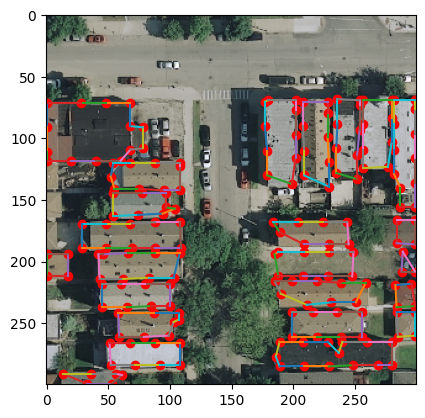

In [3]:
dataset = CrowdAI(images_directory='/nas/tsgil/dataset/Inria_building/cocostyle/images',
                    annotations_path='/nas/tsgil/dataset/Inria_building/cocostyle/annotation.json')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=6, collate_fn=image_graph_collate_road_network_coco)

print(next(iter(dataloader))[0].shape) # image

data = next(iter(dataloader))

# 6개의 이미지 중 1번째 GT
image = data[0][1].detach().cpu().numpy().transpose(1,2,0)
heatmap =  data[1][1].detach().cpu().numpy()
nodes = data[2][1].detach().cpu().numpy() * image.shape[0]
edges = data[3][1].detach().cpu().numpy()

nodes = nodes.astype('int64')

# Visualize
plt.imshow(min_max_normalize(image, 0))
plt.scatter(nodes[:,1], nodes[:,0], color='r')

for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    plt.plot(connect[:,1], connect[:,0])
plt.show()

TopDiG, 백본 ckpt 불러오기

In [4]:
config_file = "/nas/tsgil/TopDiG_train/runs/baseline_TopDiG_train_epoch20_sinkhorn_diag_10/config.yaml"
config_file2 = "configs/inria_pretrain.yaml"
ckpt_backbone_path = "/nas/tsgil/gil/picked_backbone/epochs_130_5e-6.pth"
# ckpt_path = "/nas/tsgil/relationformer/work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_weighted_ce_10/models/epochs_20.pth"
# ckpt_path = "/nas/tsgil/relationformer/work_dirs/TopDiG_train/runs/baseline_TopDiG_train_epoch20_diag_weight_10/models/epochs_20.pth"
ckpt_path = "/nas/tsgil/TopDiG_train/runs/baseline_TopDiG_train_epoch20_sinkhorn_diag_10/models/epochs_4.pth"

with open(config_file) as f:
    config = yaml.load(f, Loader=yaml.FullLoader)
config = dict2obj(config)

with open(config_file2) as f:
    config2 = yaml.load(f, Loader=yaml.FullLoader)
config2 = dict2obj(config2)

model = build_TopDiG(config) # 빌드 함수 내부에서 ckpt 파일 로드함

checkpoint = torch.load(ckpt_backbone_path, map_location='cpu')
print(checkpoint['model_state_dict'].keys())
print(model.state_dict().keys())

# 파라미터 동일한지 판별
# test = True
# for key in checkpoint['model_state_dict'].keys():
#     if not torch.equal(model.state_dict()[f'backbone.{key}'],checkpoint['model_state_dict'][key]):
#         print('N')
#         test = False
# print(test)
# test = True
# for key in checkpoint['model_state_dict'].keys():
#     if not torch.equal(model.backbone.state_dict()[key],checkpoint['model_state_dict'][key]):
#         print('N')
#         test = False
# print(test)
# if torch.equal(model.state_dict()['backbone.encoder.RRCNN1.RCNN.0.conv.0.weight'], checkpoint['model_state_dict']['encoder.RRCNN1.RCNN.0.conv.0.weight']):
#     print('Y')
# if torch.equal(model.backbone.state_dict()['encoder.RRCNN1.RCNN.0.conv.0.weight'], checkpoint['model_state_dict']['encoder.RRCNN1.RCNN.0.conv.0.weight']):
#     print('Y')

checkpoint2 = torch.load(ckpt_path, map_location='cpu')
missing_keys, unexpected_keys = model.load_state_dict(checkpoint2['model_state_dict'], strict=False) # 여기서 TopDiG 학습한 체크포인트 로드
unexpected_keys = [k for k in unexpected_keys if not (k.endswith('total_params') or k.endswith('total_ops'))]
if len(missing_keys) > 0:
    print('Missing Keys: {}'.format(missing_keys))
if len(unexpected_keys) > 0:
    print('Unexpected Keys: {}'.format(unexpected_keys))
# model.eval()
device = torch.device("cuda")
# device = torch.device("cpu")
model = model.to(device)

odict_keys(['encoder.RRCNN1.RCNN.0.conv.0.weight', 'encoder.RRCNN1.RCNN.0.conv.0.bias', 'encoder.RRCNN1.RCNN.0.conv.1.weight', 'encoder.RRCNN1.RCNN.0.conv.1.bias', 'encoder.RRCNN1.RCNN.0.conv.1.running_mean', 'encoder.RRCNN1.RCNN.0.conv.1.running_var', 'encoder.RRCNN1.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN1.RCNN.1.conv.0.weight', 'encoder.RRCNN1.RCNN.1.conv.0.bias', 'encoder.RRCNN1.RCNN.1.conv.1.weight', 'encoder.RRCNN1.RCNN.1.conv.1.bias', 'encoder.RRCNN1.RCNN.1.conv.1.running_mean', 'encoder.RRCNN1.RCNN.1.conv.1.running_var', 'encoder.RRCNN1.RCNN.1.conv.1.num_batches_tracked', 'encoder.RRCNN1.Conv_1x1.weight', 'encoder.RRCNN1.Conv_1x1.bias', 'encoder.RRCNN2.RCNN.0.conv.0.weight', 'encoder.RRCNN2.RCNN.0.conv.0.bias', 'encoder.RRCNN2.RCNN.0.conv.1.weight', 'encoder.RRCNN2.RCNN.0.conv.1.bias', 'encoder.RRCNN2.RCNN.0.conv.1.running_mean', 'encoder.RRCNN2.RCNN.0.conv.1.running_var', 'encoder.RRCNN2.RCNN.0.conv.1.num_batches_tracked', 'encoder.RRCNN2.RCNN.1.conv.0.weight', 'enc

In [5]:
images = torch.zeros((6,3,320,320)).to(device)
for i, image in enumerate(data[0]):
    image = resize(image, (3, 320, 320), anti_aliasing=True, preserve_range=True)
    images[i] = torch.tensor(image).to(device)
with torch.no_grad():
    out = model(images)
scores1, scores2 = out['scores1'], out['scores2']
htm_TopDiG, nms_TopDiG = out['pred_heatmaps'], (out['pred_nodes']*320)
print(htm_TopDiG[1].unique())

tensor([-87.7903, -87.7850, -87.6560,  ...,   4.4833,   4.5458,   4.6554],
       device='cuda:0')


R2U-Net 모델에 ckpt 로드하여 NMS 결과 시각화

In [6]:
# R2U = build_backbone(config2).to(device)
# ckpt = checkpoint
# R2U.load_state_dict(ckpt['model_state_dict'])
# # R2U.eval()
# R2U.train()
# ftm_R2U, htm_R2U, nms_R2U = R2U(images)
# print(htm_R2U[1].unique())
# image = images[1].detach().cpu().numpy().transpose(1,2,0)
# nodes = nms_R2U[1][1].detach().cpu().numpy()

# # Visualize
# plt.imshow(min_max_normalize(image, 0))
# plt.scatter(nodes[:,1], nodes[:,0], color='r')

# plt.show()

matcher로 256개의 노드에 대한 엣지 뽑기 테스트

In [7]:
from scipy.optimize import linear_sum_assignment # Scipy에 구현된 헝가리안 알고리즘 사용

def scores_to_permutations(scores): # 인퍼런스용 함수
    """
    Input a batched array of scores and returns the hungarian optimized 
    permutation matrices.
    """
    B, N, N = scores.shape

    scores = scores.detach().cpu().numpy()
    perm = np.zeros_like(scores)
    for b in range(B):
        # sinkhorn 알고리즘은 비공개된 트레인 파일에 있을 듯
        # 반복적인 노멀라이제이션(100번)을 위해 싱크홀 알고리즘 사용
        # 인퍼런스시에 헝가리안 알고리즘으로 linear sum assignment result 뽑는다
        r, c = linear_sum_assignment(-scores[b]) # 점수가 높을 수록 페어일 확률이 높으므로 -를 붙여서 최소 찾는 문제로 바꾼다.
        perm[b,r,c] = 1 # 헝가리안 알고리즘이 찾은 칸은 1로 아니면 0인 permutation matrix (B N N) 만든다
    return torch.tensor(perm) # 텐서로 바꿔주기

In [8]:
scores1[1].unique()


tensor([-12.7854, -12.3932, -12.2332,  ...,  -0.5824,  -0.4854,  -0.1582],
       device='cuda:0')

torch.Size([6, 256, 256])
0 59
1 133
2 79
3 1
4 153
5 199
6 7
7 83
8 58
10 4
11 120
12 126
13 108
14 114
15 231
16 22
17 27
18 97
19 178
20 36
21 119
22 164
23 137
24 35
25 85
26 24
27 61
28 116
29 201
30 72
31 47
32 167
33 122
34 156
35 81
36 250
37 43
38 152
39 230
40 5
41 38
42 157
43 216
44 53
45 15
46 3
47 194
48 21
49 17
50 51
51 168
52 93
53 124
54 69
55 217
56 200
57 13
58 82
59 253
60 89
61 49
62 52
63 196
64 140
65 20
66 8
67 64
68 28
69 228
70 18
71 186
72 209
73 232
74 105
75 107
76 96
77 121
78 19
79 76
80 12
81 26
82 131
83 123
84 166
85 92
87 55
88 25
89 46
90 136
91 34
92 195
93 138
94 39
95 104
96 161
97 190
98 77
99 91
100 30
102 88
103 29
104 181
105 234
106 23
107 84
108 251
110 42
111 127
112 11
113 165
114 115
115 74
116 149
117 192
118 33
119 238
120 174
121 118
122 98
123 48
124 222
125 214
126 80
127 189
128 37
129 218
130 6
131 66
132 147
133 60
135 207
136 68
137 175
138 146
139 227
140 111
141 117
142 221
143 103
144 204
145 125
146 248
147 197
148 10
149 90

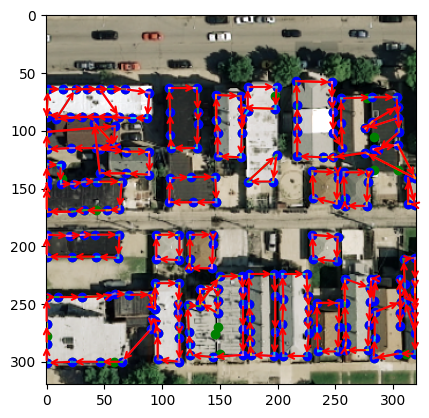

In [18]:
idx_of_batch = 5



scores = scores1.sigmoid() + scores2.transpose(1,2).sigmoid()
# # scores = scores1 + scores2
# for b in range(len(scores)):
#     diagonal = torch.diag(scores[b])*2
#     for i in range(diagonal.size(0)):
#         scores[b, i, i] = diagonal[i]

permu = scores_to_permutations(scores)
print(permu.shape)
mat = permu[idx_of_batch].numpy()
edges = []
for i in range(len(mat)):
    for j in range(len(mat)):
        if mat[i][j] == 1:
            if i != j:
                print(i, j)
                edges.append((i,j))
nodes = nms_TopDiG[1].detach().cpu().numpy()
image = images[idx_of_batch].detach().cpu().numpy().transpose(1,2,0)
nodes = nodes[idx_of_batch]
# print(nodes)

print("예측 노드 수:", len(nodes))
print("선택된 예측 노드 수:", len(edges))
print("정답 노드 수:", len(data[2][1].detach().cpu().numpy()))

# Visualize
plt.imshow(min_max_normalize(image, 0.5))
plt.scatter(nodes[:,1], nodes[:,0], color='g')
for x, _ in edges:
    plt.scatter(nodes[x][1], nodes[x][0], color='b')
for e in edges:
    connect = np.stack([nodes[e[0]], nodes[e[1]]], axis=0)
    plt.plot(connect[:,1], connect[:,0])
    plt.annotate("", xy=nodes[e[0]][::-1], xytext=nodes[e[1]][::-1], 
                arrowprops=dict(arrowstyle="->", lw=1.5, color='r'))

plt.show()

tensor(-3.2157, device='cuda:0')
tensor(-2.4225, device='cuda:0')
tensor(-2.8593, device='cuda:0')
tensor(-2.7651, device='cuda:0')
tensor(-2.8799, device='cuda:0')
tensor(-2.0081, device='cuda:0')
tensor(-3.8763, device='cuda:0')
tensor(-3.1185, device='cuda:0')
tensor(-2.9341, device='cuda:0')
tensor(-2.6959, device='cuda:0')
tensor(-1.9516, device='cuda:0')
tensor(-2.7123, device='cuda:0')
tensor(-3.0377, device='cuda:0')
tensor(-4.3409, device='cuda:0')
tensor(-4.1219, device='cuda:0')
tensor(-2.6348, device='cuda:0')
tensor(-2.0752, device='cuda:0')
tensor(-4.0508, device='cuda:0')
tensor(-4.1523, device='cuda:0')
tensor(-3.1847, device='cuda:0')
tensor(-3.0162, device='cuda:0')
tensor(-1.9716, device='cuda:0')
tensor(-3.0750, device='cuda:0')
tensor(-4.1582, device='cuda:0')
tensor(-1.5134, device='cuda:0')
tensor(-2.5603, device='cuda:0')
tensor(-3.2477, device='cuda:0')
tensor(-1.9789, device='cuda:0')
tensor(-3.6913, device='cuda:0')
tensor(-2.6995, device='cuda:0')
tensor(-4.

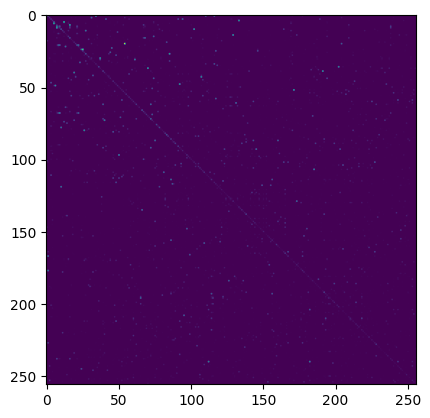

In [10]:
plt.imshow(scores1[1].sigmoid().cpu().numpy())

for i in range(256):
    print(scores1[1][i][i])

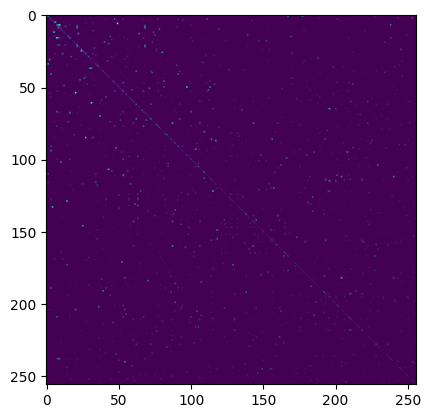

In [11]:
plt.imshow(scores2[1].sigmoid().cpu().numpy())